<center><h1> AutoSF </h1></center>

AutoSF (Auto Scoring Function) (https://arxiv.org/pdf/1904.11682.pdf) is an algorithm for automatically finding the scoring function in the embedding space for Knowledge Graphs (KGs).



# Open Graph Benchmark Library (OGBL) - BioKG

<b>Graph</b> : The ogbl-biokg dataset is a Knowledge Graph (KG), which we created using data from a large number of biomedical data repositories. It contains 5 types of entities: diseases (10,687 nodes), proteins (17,499), drugs (10,533 nodes), side effects (9,969 nodes), and protein functions (45,085 nodes). There are 51 types of directed relations connecting two types of entities, including 39 kinds of drug-drug interactions, 8 kinds of protein-protein interaction, as well as drug-protein, drug-side effect, drug-protein, function-function relations. All relations are modeled as directed edges, among which the relations connecting the same entity types (e.g., protein-protein, drug-drug, function-function) are always symmetric, i.e., the edges are bi-directional.

This dataset is relevant to both biomedical and fundamental ML research. On the biomedical side, the dataset allows us to get better insights into human biology and generate predictions that can guide downstream biomedical research. On the fundamental ML side, the dataset presents challenges in handling a noisy, incomplete KG with possible contradictory observations. This is because the ogbl-biokg dataset involves heterogeneous interactions that span from the molecular scale (e.g., protein-protein interactions within a cell) to whole populations (e.g., reports of unwanted side effects experienced by patients in a particular country). Further, triplets in the KG come from sources with a variety of confidence levels, including experimental readouts, human-curated annotations, and automatically extracted metadata.

<b>Prediction task</b>: The task is to predict new triplets given the training triplets. The evaluation protocol is exactly the same as ogbl-wikikg2, except that here we only consider ranking against entities of the same type. For instance, when corrupting head entities of the protein type, we only consider negative protein entities.

<b>Dataset splitting</b>: For this dataset, we adopt a random split. While splitting the triplets according to time is an attractive alternative, we note that it is incredibly challenging to obtain accurate information as to when individual experiments and observations underlying the triplets were made. We strive to provide additional dataset splits in future versions of the OGB.



# Installing libraries (OGB & TorchKGE)

The OGB (Open Graph Benchmark) library is used in this notebook to retrieve the knowledge graph and to evaluate our model.<br/>
The TorchKGE library is used to create our model.

In [ ]:
# Installing OBG to download dataset
!pip install ogb

# Getting TorchKGE library
!git clone https://github.com/torchkge-team/torchkge.git
!mv /content/torchkge /content/torchkge_repo
!mv /content/torchkge_repo/torchkge /content/torchkge
!pip install -r /content/torchkge_repo/requirements_dev.txt

     |████████████████████████████████| 71kB 6.7MB/s 
  Created wheel for littleutils: filename=littleutils-0.2.2-cp37-none-any.whl size=7051 sha256=f8390c39ff9b629ec592444dcc6dff9f4bc25a22c1ded400db0325ea64cb5f23
  Stored in directory: /root/.cache/pip/wheels/53/16/9f/ac67d15c40243754fd73f620e1b9b6dedc20492ecc19a2bae1
Successfully built littleutils
Cloning into 'torchkge'...
remote: Enumerating objects: 3410, done.
remote: Counting objects: 100% (89/89), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 3410 (delta 54), reused 82 (delta 52), pack-reused 3321
Receiving objects: 100% (3410/3410), 794.66 KiB | 18.06 MiB/s, done.
Resolving deltas: 100% (2256/2256), done.
     |████████████████████████████████| 2.9MB 13.9MB/s 
     |████████████████████████████████| 9.2MB 46.2MB/s 
     |████████████████████████████████| 51kB 8.1MB/s 
     |████████████████████████████████| 81kB 12.6MB/s 
     |████████████████████████████████| 92kB 13.7MB/s 
     |██████████████████████

# Imports

In [ ]:
# General Purpose imports
import os
import sys
import json
import time
import tqdm
from copy import copy

# Math / Data structures imports
import math
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

# PyTorch imports
import torch                                                # PyTorch
from torch import cuda                                      # CUDA device
from torch.optim import Adam                                # Adam optimizer

# OGB Improts
from ogb.linkproppred import Evaluator                      # Evaluates model
from ogb.linkproppred.dataset import LinkPropPredDataset    # Loads KG 

# TorchKGE imports
import torchkge
from torchkge.utils.data import DataLoader                  # Loads batches
from torchkge.utils.losses import MarginLoss                # Loss function
from torchkge.models.bilinear import ComplExModel           # KGE Model
from torchkge.data_structures import KnowledgeGraph         # KG object
from torchkge.sampling import BernoulliNegativeSampler      # Corrupts triplets

# Accessing data

In [ ]:
dataset = LinkPropPredDataset(name = 'ogbl-biokg')

Downloaded 0.90 GB: 100%|██████████| 920/920 [04:23<00:00,  3.50it/s]


Extracting dataset/biokg.zip
Loading necessary files...
This might take a while.


100%|██████████| 1/1 [00:00<00:00, 725.91it/s]

Processing graphs...
Saving...


In [ ]:
# Getting the dataset train-val-test split
split_set = dataset.get_edge_split()
train_set, valid_set, test_set = split_set["train"], split_set["valid"], split_set["test"]


def type_and_id_2_new_id(typ, id):
  base = 0

  if 'dis' in typ:
    base += 0
  elif 'prot' in typ:
    base = 10_687
  elif 'drug' in typ:
    base = 10_687 + 17_499
  elif 'effe' in typ:
    base = 10_687 + 17_499 + 10_533
  elif 'fun' in typ:
    base = 10_687 + 17_499 + 10_533 + 9_969

  return base + id

def trainset_to_newset(train_set):
  tmp_set = []

  for ht, h, r, tt, t in zip(train_set['head_type'], train_set['head'], train_set['relation'], train_set['tail_type'], train_set['tail']):
    head_id = type_and_id_2_new_id(ht, h)
    tail_id = type_and_id_2_new_id(tt, t)
  
    tmp_set.append([head_id, r, tail_id])
  
  return pd.DataFrame(np.array(tmp_set), columns=['head', 'relation', 'tail'])

def valset_to_newset(val_set):
  tmp_set = []

  for ht, h, nhs, r, tt, t, nts in zip(val_set['head_type'], val_set['head'], val_set['head_neg'], val_set['relation'], val_set['tail_type'], val_set['tail'], val_set['tail_neg']):
    h_id = type_and_id_2_new_id(ht, h)
    t_id = type_and_id_2_new_id(tt, t)

    nh_ids, nt_ids = [], []
    for nh, nt in zip(nhs, nts):
      nh_id = type_and_id_2_new_id(ht, nh)
      nt_id = type_and_id_2_new_id(tt, nt)

      nh_ids.append(nh_id)
      nt_ids.append(nt_id)

    tmp_set.append([h_id, nh_ids, r, t_id, nt_ids])
  
  return pd.DataFrame(np.array(tmp_set), columns=['head', 'head_neg', 'relation', 'tail', 'tail_neg'])
  
train_set = trainset_to_newset(train_set)
valid_set = valset_to_newset(valid_set)
test_set = valset_to_newset(test_set)

# Getting the sets of entities and relations (IDs)
train_set_df = pd.DataFrame(train_set)
entities_set = set(list(set(train_set_df['head'])) + list(set(train_set_df['tail'])))
relations_set = set(train_set['relation'])

# Showing infos
print(train_set_df)
print("Number of distinct entities: ", len(entities_set))
print("Number of distinct relations: ", len(relations_set))

        head_type   head  relation tail_type   tail
0         disease   1718         0   protein   3207
1         disease   4903         0   protein  13662
2         disease   5480         0   protein  15999
3         disease   3148         0   protein   7247
4         disease  10300         0   protein  16202
...           ...    ...       ...       ...    ...
4762673   protein  13866        50   protein  11683
4762674   protein  10825        50   protein    657
4762675   protein  12658        50   protein  11999
4762676   protein  12028        50   protein   2482
4762677   protein   2096        50   protein   2093

[4762678 rows x 5 columns]
Number of distinct entities:  45085
Number of distinct relations:  51


In [ ]:
# Defining our knowledge graph
print("Creating TorchKGE knowledge graph object. This might take a while...")
bio_knowledge_graph = KnowledgeGraph(df=pd.DataFrame(np.array(train_set_df[['head', 'tail', 'relation']]), columns=['from', 'to', 'rel']))
print("Knowledge Graph created successfully!")

Creating TorchKGE knowledge graph object. This might take a while...
Knowledge Graph created successfully!


# Defining the evaluation function

We have 162886 actual facts, we want to see where each actual fact gets ranked when compared with 500 corrupted facts.<br/>
The Mean-Reciprocal Ranking (MRR) is computed as $MRR = \frac{1}{N}\sum_i^N\frac{1}{r_i}$ where $r_i$ is the rank of the i-th correct fact (from 1 to 501st). Best possible model always rank correct facts first (i.e. $r_i=1, \ \ \forall i)$ and obtains an MRR of 1.

In [ ]:
def evaluate(eval_set, model):
  # OGB Evaluator
  evaluator = Evaluator('ogbl-biokg')

  # Loading test / evaluation data as (h,t,r) and (h',t',r) triplets
  heads, tails, relations = eval_set['head'], eval_set['tail'], eval_set['relation']
  heads_n, tails_n = eval_set['head_neg'], eval_set['tail_neg']

  # Conversion to PyTorch tensors and in cuda memory
  # heads, tails, relations = torch.tensor(heads).cuda(), torch.tensor(tails).cuda(), torch.tensor(relations).cuda()
  # heads_n, tails_n = torch.tensor(heads_n).cuda(), torch.tensor(tails_n).cuda()

  # print(heads.shape, tails.shape, relations.shape, heads_n.shape, tails_n.shape)

  # Getting predictions on test / evaluation set
  # model(heads, tails, heads_n, tails_n, relations) # Is this allowed ???
  counter = 0
  y_pred_pos, y_pred_neg = [], []
  for h, t, r, hs_n, ts_n in zip(heads, tails, relations, heads_n, tails_n):
    h = torch.tensor(500 * [h]).cuda()
    t = torch.tensor(500 * [t]).cuda()
    r = torch.tensor(500 * [r]).cuda()
    h_n = torch.tensor(hs_n).cuda().view(-1)
    t_n = torch.tensor(ts_n).cuda().view(-1)
    
    with torch.no_grad():
      y_pos, y_neg = model(h, t, h_n, t_n, r)
      y_pred_pos.append(y_pos.cpu().numpy()[0])
      y_pred_neg.append(y_neg.cpu().numpy())
        
  # Evaluating predictions
  metrics = evaluator.eval({
      'y_pred_pos': np.array(y_pred_pos), # Predictions on the actual facts
      'y_pred_neg': np.array(y_pred_neg),    # Predictions on the corrupted facts
  })

  mrr = metrics['mrr_list'].mean()
  return mrr

# Learning embeddings and scoring function

The implementation provided by TorchKGE (https://github.com/torchkge-team/torchkge) seems to be the fastest open-source KGE implementation available. Documentation: https://torchkge.readthedocs.io/en/latest/

  0%|          | 0/100 [00:00<?, ?epoch/s]

Found CUDA device and moving model to it


Epoch 100 | mean loss: 1291.97455: 100%|██████████| 100/100 [17:33<00:00, 10.54s/epoch]


Training finished
Best validation MRR is 0.7856132388114929 (epoch 60)
Model parameters were normalized


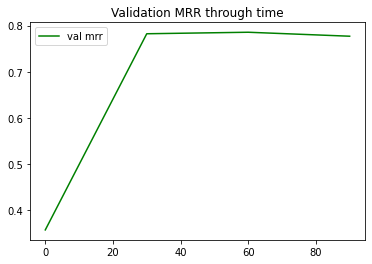

In [ ]:
def train_complex_model(k, n_ent, n_rel, lr, batch_size, n_epochs, margin, validation_frequency, model_weights_path='best_model_weights.pth'):
  # Plotting variables
  best_val_mrr = 0
  best_val_epoch = 0
  val_mrrs = []
  number_corrupted_batches = 300

  # Creation of model, optimizer and loss function
  model = ComplExModel(k, n_ent, n_rel)
  optimizer = Adam(model.parameters(), lr=lr, weight_decay=1e-5)
  criterion = MarginLoss(margin)

  # Sampler and DataLoader to load legit and corrupted facts 
  sampler = BernoulliNegativeSampler(bio_knowledge_graph)
  data_loader = DataLoader(bio_knowledge_graph, batch_size=batch_size, use_cuda='all')

  # Moving model and loss to cuda (GPU)
  if cuda.is_available():
    print("Found CUDA device and moving model to it")
    cuda.empty_cache()
    model.cuda()
    criterion.cuda()

  # Training loop
  iterator = tqdm.tqdm(range(n_epochs), unit='epoch')
  for epoch in iterator:
      running_loss = 0.0
      for i, batch in enumerate(data_loader):
          h, t, r = batch[0], batch[1], batch[2]

          
          n_h, n_t = sampler.corrupt_batch(h, t, r)
          # forward + backward + optimize
          pos, neg = model(h, t, n_h, n_t, r)
          loss = criterion(pos, neg)

          loss.backward()
          optimizer.step()
          optimizer.zero_grad()

          running_loss += loss.item()
      iterator.set_description(
          'Epoch {} | mean loss: {:.5f}'.format(
              epoch + 1,
              running_loss / len(data_loader)
            )
      )

      if epoch % validation_frequency == 0:
        mrr = evaluate(valid_set, model)
        val_mrrs.append(mrr)
        if mrr > best_val_mrr:
          best_val_mrr = mrr
          best_val_epoch = epoch
          torch.save(model, model_weights_path)

  print("\nTraining finished")
  print("Best validation MRR is {} (epoch {})".format(best_val_mrr, best_val_epoch))
  # Normalizing parameters after training is done
  model.normalize_parameters()
  print("Model parameters were normalized")

  plt.plot(np.arange(len(val_mrrs)) * validation_frequency, val_mrrs, 'g-', label='val mrr')
  plt.legend()
  plt.title("Validation MRR through time")
  plt.show()

  return model, best_val_mrr


# Training parameters
k, n_ent, n_rel = 800, len(entities_set), len(relations_set)
lr = 0.001
batch_size = 100_000
n_epochs = 100
margin = 0.5
validation_frequency = 3

model, mrr = train_complex_model(k, n_ent, n_rel, lr, batch_size, n_epochs, margin, validation_frequency)

# Grid search of Hyper-parameters





  0%|          | 0/85 [00:00<?, ?epoch/s]

Found CUDA device and moving model to it






Epoch 1 | mean loss: 396880.58854:   0%|          | 0/85 [00:04<?, ?epoch/s]



Epoch 1 | mean loss: 396880.58854:   1%|          | 1/85 [02:24<3:21:59, 144.28s/epoch]



Epoch 2 | mean loss: 395183.56315:   1%|          | 1/85 [02:28<3:21:59, 144.28s/epoch]



Epoch 2 | mean loss: 395183.56315:   2%|▏         | 2/85 [02:28<2:21:24, 102.23s/epoch]



Epoch 3 | mean loss: 367640.30632:   2%|▏         | 2/85 [02:32<2:21:24, 102.23s/epoch]



Epoch 3 | mean loss: 367640.30632:   4%|▎         | 3/85 [02:32<1:39:28, 72.79s/epoch] 



Epoch 4 | mean loss: 253828.62467:   4%|▎         | 3/85 [02:36<1:39:28, 72.79s/epoch]



Epoch 4 | mean loss: 253828.62467:   5%|▍         | 4/85 [02:36<1:10:26, 52.18s/epoch]



Epoch 5 | mean loss: 149900.53076:   5%|▍         | 4/85 [02:40<1:10:26, 52.18s/epoch]



Epoch 5 | mean loss: 149900.53076:   6%|▌         | 5/85 [02:40<50:20, 37.76s/epoch]  



Epoch 6 | mean loss: 74805.78654:   6%|▌         | 5/85 [02:44<50:20, 37.76s/epoch] 



Epoch 6 | mea


Training finished
Best validation MRR is 0.7855876684188843 (epoch 84)
Model parameters were normalized


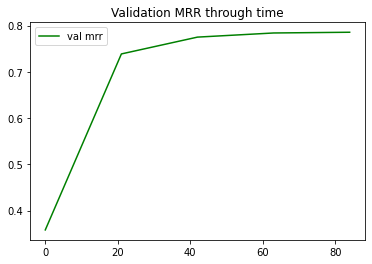

k: 650
lr: 0.0015
margin: 4
0.78558767






  0%|          | 0/85 [00:00<?, ?epoch/s]

Found CUDA device and moving model to it






Epoch 1 | mean loss: 1190659.26172:   0%|          | 0/85 [00:04<?, ?epoch/s]



Epoch 1 | mean loss: 1190659.26172:   1%|          | 1/85 [02:23<3:20:15, 143.05s/epoch]



Epoch 2 | mean loss: 1188867.22526:   1%|          | 1/85 [02:27<3:20:15, 143.05s/epoch]



Epoch 2 | mean loss: 1188867.22526:   2%|▏         | 2/85 [02:27<2:20:13, 101.36s/epoch]



Epoch 3 | mean loss: 1160420.33333:   2%|▏         | 2/85 [02:31<2:20:13, 101.36s/epoch]



Epoch 3 | mean loss: 1160420.33333:   4%|▎         | 3/85 [02:31<1:38:38, 72.18s/epoch] 



Epoch 4 | mean loss: 1021415.39323:   4%|▎         | 3/85 [02:35<1:38:38, 72.18s/epoch]



Epoch 4 | mean loss: 1021415.39323:   5%|▍         | 4/85 [02:35<1:09:51, 51.75s/epoch]



Epoch 5 | mean loss: 721791.90495:   5%|▍         | 4/85 [02:39<1:09:51, 51.75s/epoch] 



Epoch 5 | mean loss: 721791.90495:   6%|▌         | 5/85 [02:39<49:56, 37.45s/epoch]  



Epoch 6 | mean loss: 475178.37565:   6%|▌         | 5/85 [02:43<49:56, 37.45s/epoch]



Epoc


Training finished
Best validation MRR is 0.7807326912879944 (epoch 84)
Model parameters were normalized


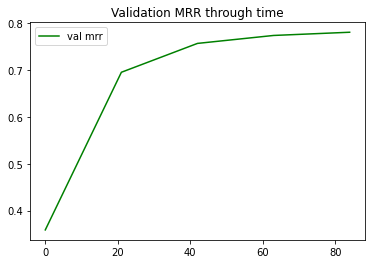





  0%|          | 0/85 [00:00<?, ?epoch/s]

Found CUDA device and moving model to it






Epoch 1 | mean loss: 396878.37142:   0%|          | 0/85 [00:04<?, ?epoch/s]



Epoch 1 | mean loss: 396878.37142:   1%|          | 1/85 [02:23<3:20:21, 143.12s/epoch]



Epoch 2 | mean loss: 394934.97201:   1%|          | 1/85 [02:27<3:20:21, 143.12s/epoch]



Epoch 2 | mean loss: 394934.97201:   2%|▏         | 2/85 [02:27<2:20:28, 101.55s/epoch]



Epoch 3 | mean loss: 363729.07943:   2%|▏         | 2/85 [02:32<2:20:28, 101.55s/epoch]



Epoch 3 | mean loss: 363729.07943:   4%|▎         | 3/85 [02:32<1:39:00, 72.45s/epoch] 



Epoch 4 | mean loss: 243467.68490:   4%|▎         | 3/85 [02:36<1:39:00, 72.45s/epoch]



Epoch 4 | mean loss: 243467.68490:   5%|▍         | 4/85 [02:36<1:10:17, 52.07s/epoch]



Epoch 5 | mean loss: 140838.05509:   5%|▍         | 4/85 [02:41<1:10:17, 52.07s/epoch]



Epoch 5 | mean loss: 140838.05509:   6%|▌         | 5/85 [02:41<50:24, 37.81s/epoch]  



Epoch 6 | mean loss: 68890.12809:   6%|▌         | 5/85 [02:45<50:24, 37.81s/epoch] 



Epoch 6 | mea


Training finished
Best validation MRR is 0.7851091027259827 (epoch 84)
Model parameters were normalized


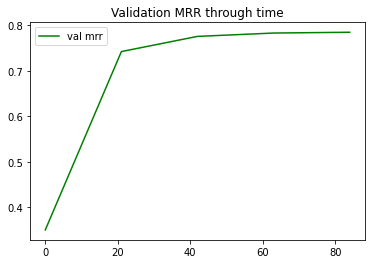





  0%|          | 0/85 [00:00<?, ?epoch/s]

Found CUDA device and moving model to it






Epoch 1 | mean loss: 1190659.29948:   0%|          | 0/85 [00:04<?, ?epoch/s]



Epoch 1 | mean loss: 1190659.29948:   1%|          | 1/85 [02:24<3:21:57, 144.25s/epoch]



Epoch 2 | mean loss: 1188790.79688:   1%|          | 1/85 [02:28<3:21:57, 144.25s/epoch]



Epoch 2 | mean loss: 1188790.79688:   2%|▏         | 2/85 [02:28<2:21:37, 102.37s/epoch]



Epoch 3 | mean loss: 1158178.30729:   2%|▏         | 2/85 [02:33<2:21:37, 102.37s/epoch]



Epoch 3 | mean loss: 1158178.30729:   4%|▎         | 3/85 [02:33<1:39:47, 73.02s/epoch] 



Epoch 4 | mean loss: 1006335.39844:   4%|▎         | 3/85 [02:37<1:39:47, 73.02s/epoch]



Epoch 4 | mean loss: 1006335.39844:   5%|▍         | 4/85 [02:37<1:10:50, 52.48s/epoch]



Epoch 5 | mean loss: 694710.53516:   5%|▍         | 4/85 [02:42<1:10:50, 52.48s/epoch] 



Epoch 5 | mean loss: 694710.53516:   6%|▌         | 5/85 [02:42<50:47, 38.09s/epoch]  



Epoch 6 | mean loss: 453214.23503:   6%|▌         | 5/85 [02:47<50:47, 38.09s/epoch]



Epoc


Training finished
Best validation MRR is 0.7822179794311523 (epoch 84)
Model parameters were normalized


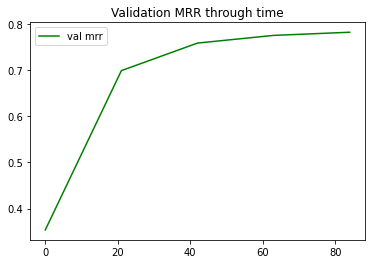

Found CUDA device and moving model to it






  0%|          | 0/85 [00:00<?, ?epoch/s]



Epoch 1 | mean loss: 396878.01953:   0%|          | 0/85 [00:05<?, ?epoch/s]



Epoch 1 | mean loss: 396878.01953:   1%|          | 1/85 [02:24<3:22:52, 144.91s/epoch]



Epoch 2 | mean loss: 394562.67285:   1%|          | 1/85 [02:30<3:22:52, 144.91s/epoch]



Epoch 2 | mean loss: 394562.67285:   2%|▏         | 2/85 [02:30<2:22:36, 103.10s/epoch]



Epoch 3 | mean loss: 355718.20996:   2%|▏         | 2/85 [02:35<2:22:36, 103.10s/epoch]



Epoch 3 | mean loss: 355718.20996:   4%|▎         | 3/85 [02:35<1:40:53, 73.83s/epoch] 



Epoch 4 | mean loss: 221784.67188:   4%|▎         | 3/85 [02:41<1:40:53, 73.83s/epoch]



Epoch 4 | mean loss: 221784.67188:   5%|▍         | 4/85 [02:41<1:12:00, 53.34s/epoch]



Epoch 5 | mean loss: 123811.49552:   5%|▍         | 4/85 [02:47<1:12:00, 53.34s/epoch]



Epoch 5 | mean loss: 123811.49552:   6%|▌         | 5/85 [02:47<51:59, 39.00s/epoch]  



Epoch 6 | mean loss: 58290.42230:   6%|▌         | 5/85 


Training finished
Best validation MRR is 0.7812908291816711 (epoch 63)
Model parameters were normalized


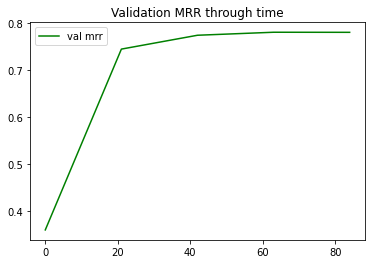

Found CUDA device and moving model to it






  0%|          | 0/85 [00:00<?, ?epoch/s]



Epoch 1 | mean loss: 1190658.34896:   0%|          | 0/85 [00:05<?, ?epoch/s]



Epoch 1 | mean loss: 1190658.34896:   1%|          | 1/85 [02:25<3:23:07, 145.09s/epoch]



Epoch 2 | mean loss: 1188353.82292:   1%|          | 1/85 [02:30<3:23:07, 145.09s/epoch]



Epoch 2 | mean loss: 1188353.82292:   2%|▏         | 2/85 [02:30<2:22:47, 103.22s/epoch]



Epoch 3 | mean loss: 1149224.30469:   2%|▏         | 2/85 [02:36<2:22:47, 103.22s/epoch]



Epoch 3 | mean loss: 1149224.30469:   4%|▎         | 3/85 [02:36<1:41:00, 73.91s/epoch] 



Epoch 4 | mean loss: 956043.97005:   4%|▎         | 3/85 [02:41<1:41:00, 73.91s/epoch] 



Epoch 4 | mean loss: 956043.97005:   5%|▍         | 4/85 [02:41<1:12:04, 53.39s/epoch]



Epoch 5 | mean loss: 624453.02637:   5%|▍         | 4/85 [02:47<1:12:04, 53.39s/epoch]



Epoch 5 | mean loss: 624453.02637:   6%|▌         | 5/85 [02:47<52:02, 39.03s/epoch]  



Epoch 6 | mean loss: 394924.84163:   6%|▌        


Training finished
Best validation MRR is 0.7804402709007263 (epoch 84)
Model parameters were normalized


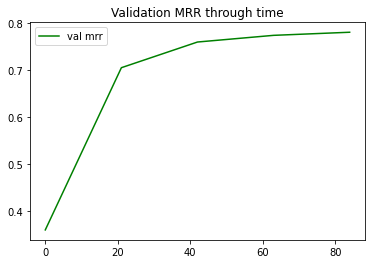

Found CUDA device and moving model to it






  0%|          | 0/85 [00:00<?, ?epoch/s]



Epoch 1 | mean loss: 396876.44466:   0%|          | 0/85 [00:06<?, ?epoch/s]



Epoch 1 | mean loss: 396876.44466:   1%|          | 1/85 [02:25<3:23:43, 145.51s/epoch]



Epoch 2 | mean loss: 394156.05599:   1%|          | 1/85 [02:31<3:23:43, 145.51s/epoch]



Epoch 2 | mean loss: 394156.05599:   2%|▏         | 2/85 [02:31<2:23:28, 103.71s/epoch]



Epoch 3 | mean loss: 348221.98828:   2%|▏         | 2/85 [02:37<2:23:28, 103.71s/epoch]



Epoch 3 | mean loss: 348221.98828:   4%|▎         | 3/85 [02:37<1:41:44, 74.45s/epoch] 



Epoch 4 | mean loss: 207554.16146:   4%|▎         | 3/85 [02:44<1:41:44, 74.45s/epoch]



Epoch 4 | mean loss: 207554.16146:   5%|▍         | 4/85 [02:44<1:12:51, 53.96s/epoch]



Epoch 5 | mean loss: 107072.40706:   5%|▍         | 4/85 [02:50<1:12:51, 53.96s/epoch]



Epoch 5 | mean loss: 107072.40706:   6%|▌         | 5/85 [02:50<52:50, 39.63s/epoch]  



Epoch 6 | mean loss: 53922.97599:   6%|▌         | 5/85 


Training finished
Best validation MRR is 0.7797947525978088 (epoch 84)
Model parameters were normalized


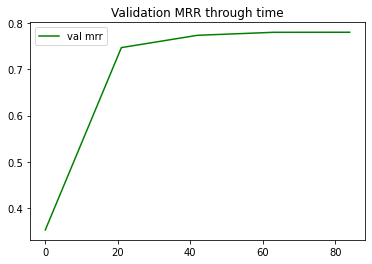

Found CUDA device and moving model to it






  0%|          | 0/85 [00:00<?, ?epoch/s]



Epoch 1 | mean loss: 1190656.49740:   0%|          | 0/85 [00:06<?, ?epoch/s]



Epoch 1 | mean loss: 1190656.49740:   1%|          | 1/85 [02:25<3:23:01, 145.02s/epoch]



Epoch 2 | mean loss: 1187975.81510:   1%|          | 1/85 [02:31<3:23:01, 145.02s/epoch]



Epoch 2 | mean loss: 1187975.81510:   2%|▏         | 2/85 [02:31<2:22:59, 103.36s/epoch]



Epoch 3 | mean loss: 1142451.82552:   2%|▏         | 2/85 [02:37<2:22:59, 103.36s/epoch]



Epoch 3 | mean loss: 1142451.82552:   4%|▎         | 3/85 [02:37<1:41:24, 74.21s/epoch] 



Epoch 4 | mean loss: 919955.38867:   4%|▎         | 3/85 [02:43<1:41:24, 74.21s/epoch] 



Epoch 4 | mean loss: 919955.38867:   5%|▍         | 4/85 [02:43<1:12:37, 53.79s/epoch]



Epoch 5 | mean loss: 582211.76790:   5%|▍         | 4/85 [02:49<1:12:37, 53.79s/epoch]



Epoch 5 | mean loss: 582211.76790:   6%|▌         | 5/85 [02:49<52:40, 39.50s/epoch]  



Epoch 6 | mean loss: 354288.07568:   6%|▌        


Training finished
Best validation MRR is 0.7808117866516113 (epoch 84)
Model parameters were normalized


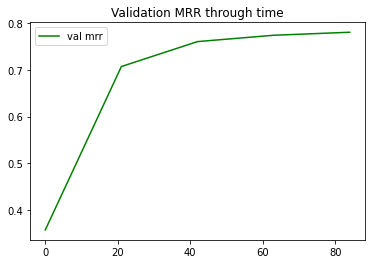

TypeError: ignored

In [ ]:
def config_to_filename(k, lr, margin):
  return "k_"+str(k)+"_lr_"+str(lr)+"_mar_"+str(margin)+".pth"

best_config = ""
best_mrr = 0

# Fixed training parameters
n_ent, n_rel = len(entities_set), len(relations_set)
batch_size = 100_000
n_epochs = 95
validation_frequency = 21

# Grid search
for k in [650, 720, 900, 1024]:
  for lr in [0.0015]:
    for margin in [4, 12]:
      filename = config_to_filename(k, lr, margin)
      model, mrr = train_complex_model(k, n_ent, n_rel, lr, batch_size, n_epochs, margin, validation_frequency, filename)
      if mrr > best_mrr:
        best_mrr = mrr
        best_config = "k: {}\nlr: {}\nmargin: {}".format(k, lr, margin)
        print(best_config)
        print(mrr)

# Logging best result
print("Best config is\n"+best_config+"\n\nmrr: "+best_mrr)

# Moving the saved model to google drive

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

In [ ]:
!cp /content/best_model_weights.pth /content/drive/MyDrive/

# Re-loading the model

In [ ]:
!cp /content/drive/MyDrive/best_model_weights.pth /content/

In [ ]:
model = ComplExModel(k, n_ent, n_rel)
model.load_state_dict(torch.load('/content/best_model_weights.pth'))

if cuda.is_available():
  model.cuda()

# Accuracy on training set (optional)

In this example test, we go through all training facts (h, t, r) and corrupt them (h', t', r) and see how many time the scoring for the actual facts are higher, i.e. f(h, t, r) > f(h', t', r). This gives a sort of training accuracy.

In [ ]:
positive_predictions, negative_predictions = [], []
for b in data_loader:
  h, t, r = b[0], b[1], b[2]
  n_h, n_t = sampler.corrupt_batch(h, t, r)

  pos_pred, neg_pred = model(h, t, n_h, n_t, r)
  positive_predictions += [t.item() for t in pos_pred]
  negative_predictions += [t.item() for t in neg_pred]

correct, total = 0, 0
for pp, np in zip(positive_predictions, negative_predictions):
  correct = correct+1 if pp > np else correct
  total += 1

print("Actual facts win over corrupted facts {}% of the times (training set)".format(correct/total*100))

# Evaluation on the test set

In [ ]:
print("Test MRR is: ", evaluate(test_set, model))

In [ ]:
print("Valid MRR is: ", evaluate(valid_set, model))